In [10]:
# Adapted from OpenAI's Vision example 
from openai import OpenAI
import pandas as pd
import base64
import re
import os
from tqdm import tqdm

# Point to the local server
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

base_path = '/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/PTYS_AI_clean/07_Neural_Networks/notebooks/data/tiled_img_brain_terrain_64'

img_descriptions = []
# List all files in the base_path directory
tracker = 0
for filename in tqdm(os.listdir(base_path)):
    # if tracker > 5:
    #   break
    path = os.path.join(base_path, filename)
    if os.path.isfile(path):
      # Read the image and encode it to base64:
      base64_image = ""
      try:
        image = open(path.replace("'", ""), "rb").read()
        base64_image = base64.b64encode(image).decode("utf-8")
      except:
        print("Couldn't read the image. Make sure the path is correct and the file exists.")
        exit()

      completion = client.chat.completions.create(
        model="xtuner/llava-llama-3-8b-v1_1-gguf",
        messages=[
          {
            "role": "system",
            "content": 
                    "You are a scientific assistant specializing in image analysis. Your task is to objectively describe the "
                    "appearance of images without any interpretation. You must provide descriptions that are precise and relate "
                    "to complexity, textures, brightness variations, and patterns in the image.",
          },
          {
            "role": "user",
            "content": [
              {"type": "text", "text": 
                            "Describe the following image objectively. Adjectives should relate to the complexity of textures, "
                            "brightness variations, or patterns of the image. Describe the overall brightness of the image as well.\n\n"},
              {
                "type": "image_url",
                "image_url": {
                  "url": f"data:image/jpeg;base64,{base64_image}"
                },
              },
            ],
          }
        ],
        max_tokens=1024,
        stream=True
      )
      
      full_response = ""
      for chunk in completion:
          if chunk.choices[0].delta.content:
              full_response += chunk.choices[0].delta.content
      edited_response = re.sub(r'<\|.*?\|>', '', full_response).strip()
      img_descriptions.append(edited_response)
      tracker += 1

img_descriptions

# save the descriptions to a file
model_name = 'llava-llama-3-8b-v1_1-gguf'
sheet_name = "descriptions"
version = '2'
img_descriptions_filename = f'img_descriptions_{model_name}_{version}.xlsx'
path = '/Users/phillipsm/Documents/Teaching/AI_workshop_2025/data/'
img_descriptions_filepath = os.path.join(path, img_descriptions_filename)

# Assuming img_descriptions is the list you want to save
data = pd.DataFrame(img_descriptions, columns=['Description'])
data.to_excel(img_descriptions_filepath, index=False)

100%|██████████| 841/841 [1:57:41<00:00,  8.40s/it]  


In [11]:
import pandas as pd
# read the descriptions from the excel file
img_descriptions_filepath = '/Users/phillipsm/Documents/Teaching/AI_workshop_2025/data/img_descriptions_llava-llama-3-8b-v1_1-gguf_2.xlsx' #'/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/Code/01_LLMs/notebooks/img_descriptions_Eris_PrimeV3-Vision-7B-GGUF-IQ-Imatrix.xlsx'
data = pd.read_excel(img_descriptions_filepath)#, sheet_name=sheet_name, header=None)
data_list = data.values.flatten().tolist()
data_list[0]

"The image presents a close-up view of a textured surface. The texture is composed of small circles and lines that are scattered across the image. The color palette is dominated by shades of gray, with occasional black spots adding contrast. The overall brightness of the image is evenly distributed, creating an impression of uniformity. However, there are some areas where the lightness appears more concentrated, providing a subtle variation in brightness across the image. There are no discernible texts or actions taking place in the image. The relative positions of the objects remain constant as the image captures a still life scene. The image does not contain any countable objects or identifiable locations. It's important to note that this description is based on the visible content of the image and does not include any speculative or imaginary elements."

In [ ]:
from openai import OpenAI
from tqdm.notebook import tqdm
client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")

model_name = "text-embedding-qwen3-embedding-0.6b"
# model_name "nomic-ai/nomic-embed-text-v1.5-GGUF"
def get_embedding(text, model=model_name):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

embeddings = []
for text in tqdm(data_list):
    embeddings.append(get_embedding(text))

print(f"Embedding vector length: {len(embeddings[0])}")
print(f"Number of embeddings: {len(embeddings)}")

  0%|          | 0/841 [00:00<?, ?it/s]

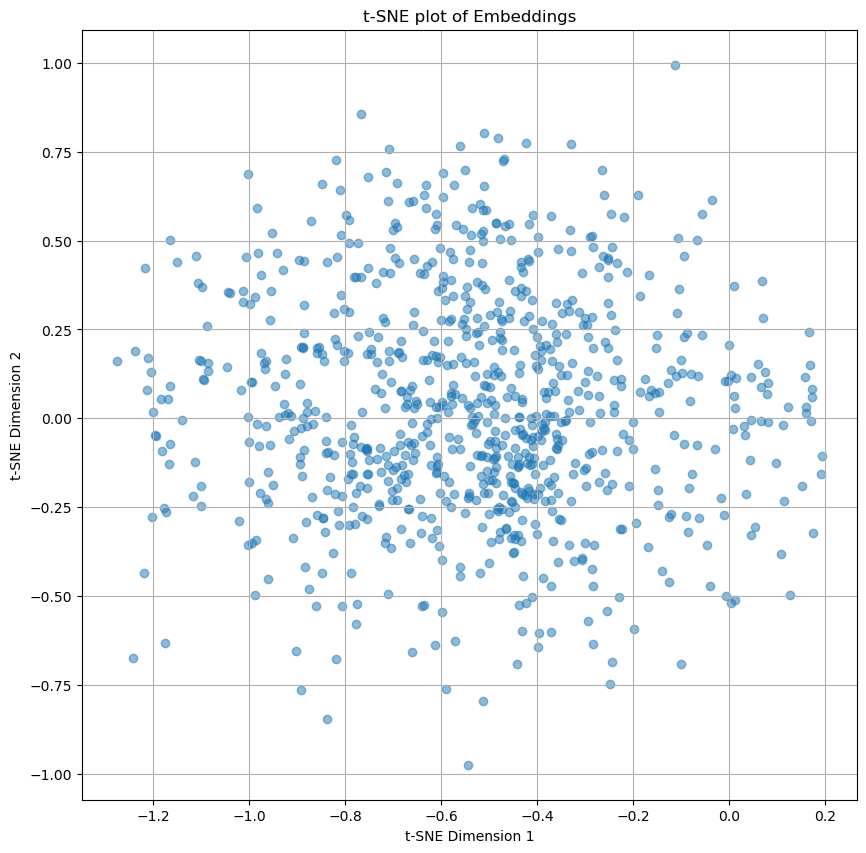

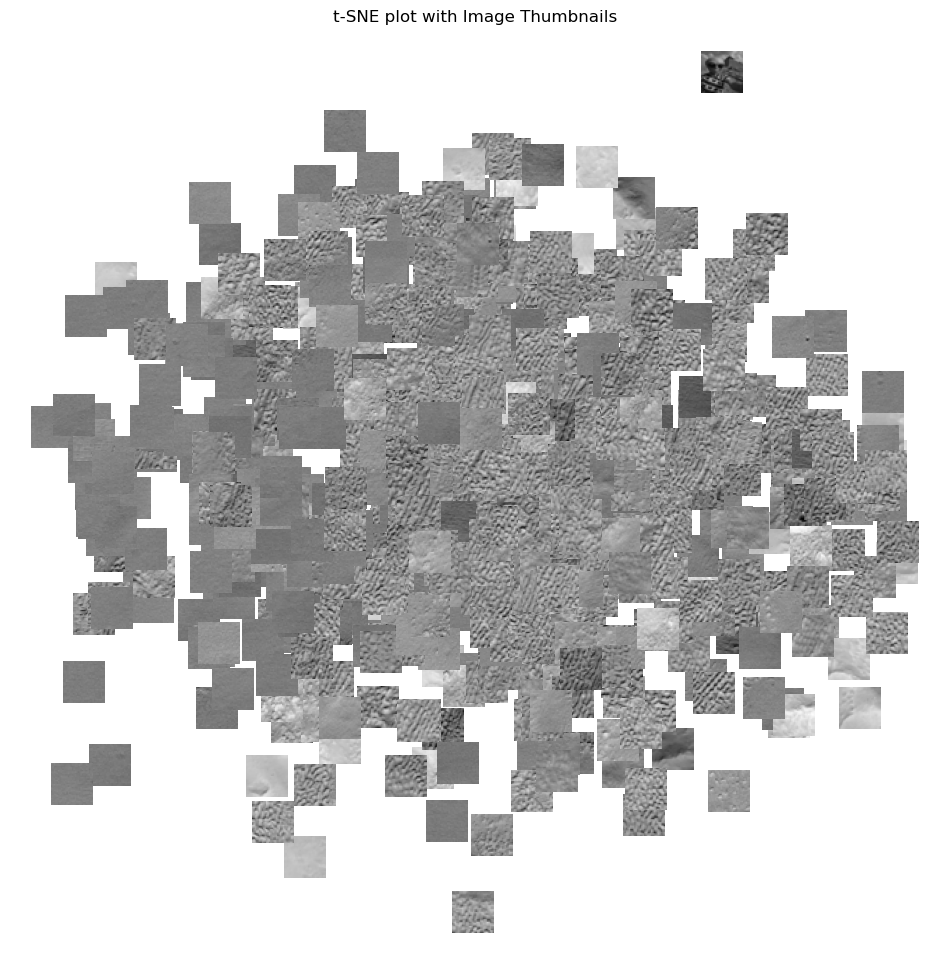

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os

base_path = '/Users/phillipsm/Documents/Teaching/AI_in_PlanetaryXXX/PTYS_AI_clean/07_Neural_Networks/notebooks/data/tiled_img_brain_terrain_64'

# Assuming 'embeddings' is the list of embeddings you want to perform TSNE on
tsne = TSNE(n_components=2, random_state=42, perplexity = 800)
embeddings_array = np.array(embeddings)
embeddings_tsne = tsne.fit_transform(embeddings_array)

plt.figure(figsize=(10, 10))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE plot of Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 12))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])

for i, ((x, y), filename) in enumerate(zip(embeddings_tsne, os.listdir(base_path))):
    # if filename.startswith('a'):
    #     continue
    img_path = os.path.join(base_path, filename)
    img = Image.open(img_path)
    img = img.resize((30, 30))  # Resize image for plotting
    imagebox = OffsetImage(img)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    plt.gca().add_artist(ab)

plt.title('t-SNE plot with Image Thumbnails')
plt.axis('off')
plt.show()


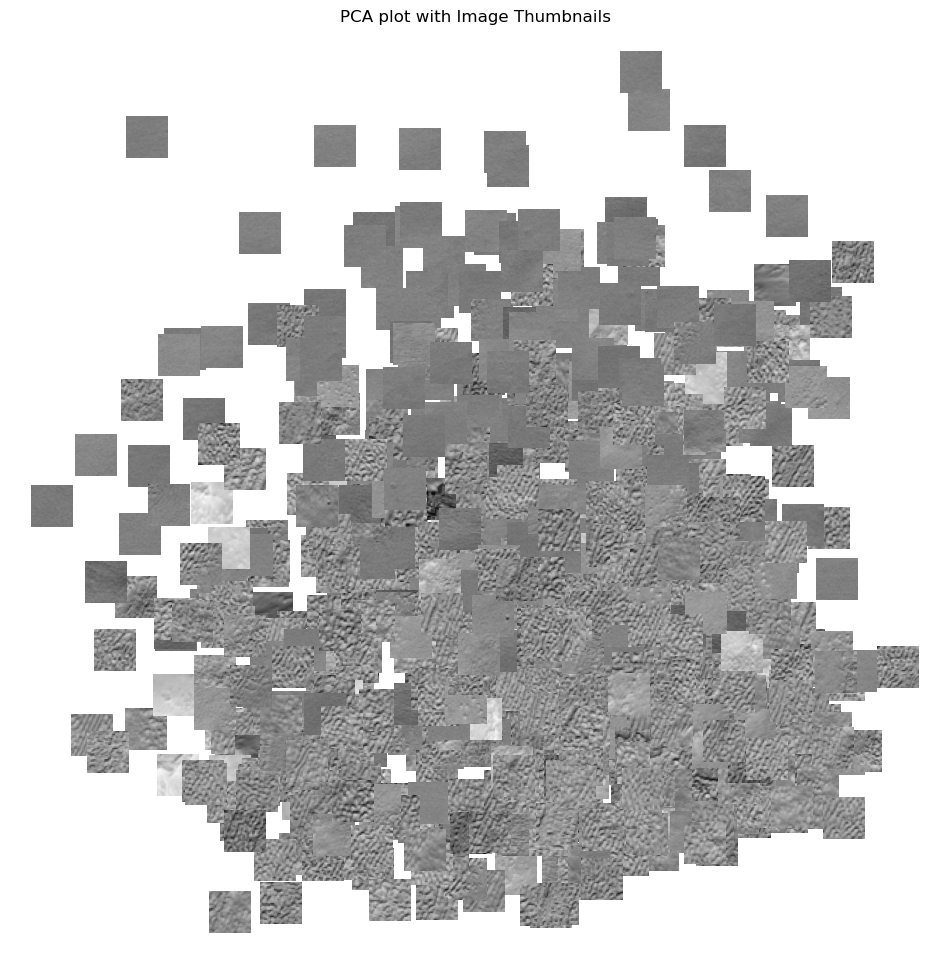

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components=12)
embeddings_pca = pca.fit_transform(embeddings)

c1, c2 = (0, 1)
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_pca[:, c1], embeddings_pca[:, c2])

for i, ((x, y), filename) in enumerate(zip(embeddings_pca[:, (c1, c2)], os.listdir(base_path))):
    img_path = os.path.join(base_path, filename)
    img = Image.open(img_path)
    img = img.resize((30, 30))  # Resize image for plotting
    imagebox = OffsetImage(img)
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    plt.gca().add_artist(ab)

plt.title('PCA plot with Image Thumbnails')
plt.axis('off')
plt.show()
